### This code focuses on the performance of three stocks: TSE 6146, TSE 6861 and TSE 7974.  These stocks were found to be in the 20 performers of the Stacked LSTM model.

In [1]:
# Please enter your choices here
securities_code = 6146
forecast_days=56
input_parameters = 100
epochs=15

# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import datetime as dt
from datetime import date,timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# create lists of Japanese Stock Market Holidays (non-weekend)
Japan_Holidays_2019 = ['2019-01-01','2019-01-02','2019-01-03','2019-01-14','2019-02-11', '2019-03-21','2019-04-29','2019-05-03','2019-05-06','2019-07-15','2019-08-12','2019-09-16','2019-09-23', '2019-10-14','2019-11-04','2019-12-31']
Japan_Holidays_2020 = ['2020-01-01', '2020-01-02', '2020-01-03','2020-01-13','2020-02-11','2020-02-24','2020-03-20','2020-04-29','2020-05-04','2020-05-05','2020-05-06','2020-07-23','2020-07-24','2020-08-10','2020-09-21','2020-09-22','2020-11-03','2020-11-23','2020-12-31']
Japan_Holidays_2021 = ['2021-01-01','2021-01-11','2021-02-11','2021-02-23','2021-04-29','2021-05-03','2021-05-04','2021-05-05','2021-07-22','2021-07-23','2021-08-09','2021-09-20','2021-09-23','2021-11-03','2021-11-23','2021-12-31']
Japan_Holidays_2022 = ['2022-01-03','2022-01-10','2022-02-11','2022-02-23','2022-03-21','2022-04-29','2022-05-03','2022-05-04','2022-05-05','2022-07-18','2022-08-11','2022-09-19','2022-09-23','2022-10-10','2022-11-03','2022-11-23']
# concatenate lists
Japan_Holidays = Japan_Holidays_2019+Japan_Holidays_2020+Japan_Holidays_2021+Japan_Holidays_2022
# convert to actual dates 
Japan_Holidays_2019to2022= [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in Japan_Holidays]

In [3]:
# Load the stock prices file
file="./train_files/stock_prices.csv"
stock_df=pd.read_csv(file)
stock_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [4]:
# check the start and end dates of the stocks
stock_df['Date'].min(),stock_df['Date'].max()

('2017-01-04', '2021-12-03')

In [5]:
# find null values
stock_df[stock_df['Close'].isnull()].isnull().sum()

RowId                  0
Date                   0
SecuritiesCode         0
Open                7608
High                7608
Low                 7608
Close               7608
Volume                 0
AdjustmentFactor       0
ExpectedDividend    7584
SupervisionFlag        0
Target               238
dtype: int64

In [6]:
# remove null values
stock_df.dropna()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
13269,20170116_2590,2017-01-16,2590,6060.0,6130.0,6060.0,6060.0,125800,1.0,30.0,False,0.005051
13726,20170116_4699,2017-01-16,4699,1119.0,1119.0,1081.0,1087.0,11500,1.0,0.0,False,-0.032833
26179,20170125_1928,2017-01-25,1928,1886.0,1894.5,1865.0,1871.5,3310500,1.0,32.0,False,-0.018336
26249,20170125_2217,2017-01-25,2217,515.0,517.0,512.0,512.0,162000,1.0,4.0,False,0.016000
26281,20170125_2353,2017-01-25,2353,153.0,154.0,151.0,152.0,431700,1.0,0.0,False,-0.006452
...,...,...,...,...,...,...,...,...,...,...,...,...
2320290,20211125_8923,2021-11-25,8923,1047.0,1051.0,1030.0,1030.0,389700,1.0,38.0,False,-0.073099
2320357,20211125_9278,2021-11-25,9278,995.0,995.0,989.0,990.0,12800,1.0,0.0,False,0.000000
2320370,20211125_9369,2021-11-25,9369,2000.0,2009.0,1989.0,1990.0,69100,1.0,23.0,False,-0.057692
2320456,20211125_9717,2021-11-25,9717,1258.0,1260.0,1222.0,1223.0,313200,1.0,50.0,False,-0.127517


In [7]:
# create a new df which will only use the "Close" column for predictions
close_df=stock_df[['Date','SecuritiesCode','Close']]
close_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,1301,2742.0
1,2017-01-04,1332,571.0
2,2017-01-04,1333,3210.0
3,2017-01-04,1376,1550.0
4,2017-01-04,1377,3330.0


# analyze TSE 6146

In [8]:
# grab just one stock 
one_stock_df=close_df.loc[close_df['SecuritiesCode']==securities_code]
one_stock_df=one_stock_df.dropna()
one_stock_df.reset_index(drop=True, inplace=True)
one_stock_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,6146,14470.0
1,2017-01-05,6146,14280.0
2,2017-01-06,6146,14090.0
3,2017-01-10,6146,14370.0
4,2017-01-11,6146,14340.0


In [9]:
len(one_stock_df)

1201

In [10]:
# convert Date column to datetime 
one_stock_df['Date'] = pd.to_datetime(one_stock_df['Date']).dt.date
one_stock_df.dtypes

Date               object
SecuritiesCode      int64
Close             float64
dtype: object

In [11]:
# only use the Close column for predicting
one_stock_close_df=one_stock_df.reset_index()['Close']
one_stock_close_df.head()

0    14470.0
1    14280.0
2    14090.0
3    14370.0
4    14340.0
Name: Close, dtype: float64

Text(0, 0.5, 'Closing Price (yen)')

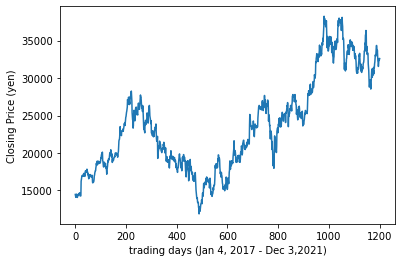

In [12]:
# look at a plot of the close prices for one stock
plt.plot(one_stock_close_df)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")

In [13]:
### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
one_stock_scaler

array([[0.09855951],
       [0.09135709],
       [0.08415466],
       ...,
       [0.77634572],
       [0.78203184],
       [0.78582259]])

In [14]:
# splitting the dataset into train and test splits
training_size=int(len(one_stock_scaler)*0.65)
test_size=len(one_stock_scaler)-training_size
train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = input_parameters
X_train, y_train=create_dataset(train_data, time_step)
X_test, y_test=create_dataset(test_data, time_step)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
# Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(int(input_parameters/2),return_sequences=True,input_shape=(input_parameters,1)))
model.add(LSTM(int(input_parameters/2),return_sequences=True))
model.add(LSTM(int(input_parameters/2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=64,verbose=1)

Epoch 1/15
11/11 [==============================] - 6s 188ms/step - loss: 0.0398 - val_loss: 0.0815
Epoch 2/15
11/11 [==============================] - 1s 96ms/step - loss: 0.0096 - val_loss: 0.0199
Epoch 3/15
11/11 [==============================] - 1s 90ms/step - loss: 0.0055 - val_loss: 0.0419
Epoch 4/15
11/11 [==============================] - 1s 84ms/step - loss: 0.0039 - val_loss: 0.0116
Epoch 5/15
11/11 [==============================] - 1s 85ms/step - loss: 0.0034 - val_loss: 0.0155
Epoch 6/15
11/11 [==============================] - 1s 83ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 7/15
11/11 [==============================] - 1s 85ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 8/15
11/11 [==============================] - 1s 94ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 9/15
11/11 [==============================] - 1s 104ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 10/15
11/11 [==============================] - 1s 98ms/step - loss: 0.0026 - val_loss: 0.0067
Epoch 1

In [21]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [22]:
# transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
# calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20749.643481225103

In [24]:
# test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

30825.812930941476

In [25]:
# calculate mean_absolute error - train data
from sklearn.metrics import mean_absolute_error as mae
mae(y_train,train_predict)

20470.55843937784

In [26]:
# test data mae
mae(y_test,test_predict)

30675.432469532396

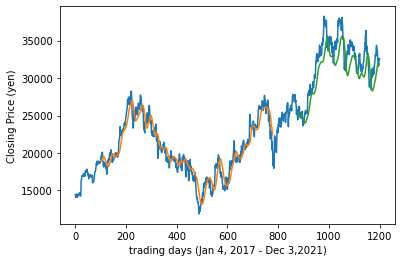

In [27]:
# Plotting
# shift train predictions for plotting
look_back=input_parameters
trainPredictPlot=np.empty_like(one_stock_scaler)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
# shift test predictions for plotting
testPredictPlot=np.empty_like(one_stock_scaler)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(one_stock_scaler)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(one_stock_scaler))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")
plt.show()

In [28]:
# setup to predict future stock prices
input_start=len(test_data)-input_parameters
x_input=test_data[input_start:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
# predictions for the amount of forecast days  
from numpy import array

lst_output=[]
n_steps=input_parameters
i=0

while(i<forecast_days):
        if(len(temp_input)>input_parameters):
            x_input=np.array(temp_input[1:])
            print("{} day input  {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
                    

[0.7470016]
101
1 day input  [0.78771797 0.81046247 0.78392722 0.8009856  0.78771797 0.76876422
 0.72896133 0.71758908 0.71190296 0.72706596 0.72517058 0.71190296
 0.74033359 0.73085671 0.74412434 0.75928734 0.77634572 0.80477635
 0.79529947 0.81235785 0.78771797 0.76307809 0.73654284 0.73275208
 0.72327521 0.75739196 0.72327521 0.71569371 0.72517058 0.74222896
 0.72896133 0.73843821 0.73654284 0.75739196 0.76497346 0.76686884
 0.78013647 0.81235785 0.82562547 0.82183472 0.86353298 0.85784685
 0.90523124 0.90712661 0.92797574 0.92228961 0.82562547 0.84836998
 0.82752085 0.80667172 0.8161486  0.8085671  0.8085671  0.75928734
 0.73843821 0.72517058 0.67437453 0.64177407 0.64253222 0.66034875
 0.67854435 0.6656558  0.64670205 0.63153904 0.65238817 0.68726308
 0.70811221 0.73275208 0.71569371 0.69105383 0.72517058 0.73654284
 0.72517058 0.70242608 0.72706596 0.71000758 0.74222896 0.74033359
 0.75928734 0.76876422 0.78961334 0.80477635 0.79719484 0.80477635
 0.82752085 0.85026535 0.85216073

11 day output [[0.6847069]]
12 day input  [0.71190296 0.74033359 0.73085671 0.74412434 0.75928734 0.77634572
 0.80477635 0.79529947 0.81235785 0.78771797 0.76307809 0.73654284
 0.73275208 0.72327521 0.75739196 0.72327521 0.71569371 0.72517058
 0.74222896 0.72896133 0.73843821 0.73654284 0.75739196 0.76497346
 0.76686884 0.78013647 0.81235785 0.82562547 0.82183472 0.86353298
 0.85784685 0.90523124 0.90712661 0.92797574 0.92228961 0.82562547
 0.84836998 0.82752085 0.80667172 0.8161486  0.8085671  0.8085671
 0.75928734 0.73843821 0.72517058 0.67437453 0.64177407 0.64253222
 0.66034875 0.67854435 0.6656558  0.64670205 0.63153904 0.65238817
 0.68726308 0.70811221 0.73275208 0.71569371 0.69105383 0.72517058
 0.73654284 0.72517058 0.70242608 0.72706596 0.71000758 0.74222896
 0.74033359 0.75928734 0.76876422 0.78961334 0.80477635 0.79719484
 0.80477635 0.82752085 0.85026535 0.85216073 0.8388931  0.80667172
 0.82752085 0.80477635 0.77255497 0.77065959 0.74601971 0.76118271
 0.78582259 0.7763457

22 day output [[0.6217182]]
23 day input  [0.73654284 0.73275208 0.72327521 0.75739196 0.72327521 0.71569371
 0.72517058 0.74222896 0.72896133 0.73843821 0.73654284 0.75739196
 0.76497346 0.76686884 0.78013647 0.81235785 0.82562547 0.82183472
 0.86353298 0.85784685 0.90523124 0.90712661 0.92797574 0.92228961
 0.82562547 0.84836998 0.82752085 0.80667172 0.8161486  0.8085671
 0.8085671  0.75928734 0.73843821 0.72517058 0.67437453 0.64177407
 0.64253222 0.66034875 0.67854435 0.6656558  0.64670205 0.63153904
 0.65238817 0.68726308 0.70811221 0.73275208 0.71569371 0.69105383
 0.72517058 0.73654284 0.72517058 0.70242608 0.72706596 0.71000758
 0.74222896 0.74033359 0.75928734 0.76876422 0.78961334 0.80477635
 0.79719484 0.80477635 0.82752085 0.85026535 0.85216073 0.8388931
 0.80667172 0.82752085 0.80477635 0.77255497 0.77065959 0.74601971
 0.76118271 0.78582259 0.77634572 0.78203184 0.78582259 0.74700159
 0.74249178 0.73766202 0.7324968  0.72702515 0.72130036 0.71538293
 0.70933187 0.70319986

33 day output [[0.56985295]]
34 day input  [0.75739196 0.76497346 0.76686884 0.78013647 0.81235785 0.82562547
 0.82183472 0.86353298 0.85784685 0.90523124 0.90712661 0.92797574
 0.92228961 0.82562547 0.84836998 0.82752085 0.80667172 0.8161486
 0.8085671  0.8085671  0.75928734 0.73843821 0.72517058 0.67437453
 0.64177407 0.64253222 0.66034875 0.67854435 0.6656558  0.64670205
 0.63153904 0.65238817 0.68726308 0.70811221 0.73275208 0.71569371
 0.69105383 0.72517058 0.73654284 0.72517058 0.70242608 0.72706596
 0.71000758 0.74222896 0.74033359 0.75928734 0.76876422 0.78961334
 0.80477635 0.79719484 0.80477635 0.82752085 0.85026535 0.85216073
 0.8388931  0.80667172 0.82752085 0.80477635 0.77255497 0.77065959
 0.74601971 0.76118271 0.78582259 0.77634572 0.78203184 0.78582259
 0.74700159 0.74249178 0.73766202 0.7324968  0.72702515 0.72130036
 0.71538293 0.70933187 0.70319986 0.69702989 0.69085681 0.68470693
 0.67860025 0.67255044 0.66656834 0.66066086 0.65483379 0.64909047
 0.64343417 0.637867

44 day output [[0.52904254]]
45 day input  [0.92797574 0.92228961 0.82562547 0.84836998 0.82752085 0.80667172
 0.8161486  0.8085671  0.8085671  0.75928734 0.73843821 0.72517058
 0.67437453 0.64177407 0.64253222 0.66034875 0.67854435 0.6656558
 0.64670205 0.63153904 0.65238817 0.68726308 0.70811221 0.73275208
 0.71569371 0.69105383 0.72517058 0.73654284 0.72517058 0.70242608
 0.72706596 0.71000758 0.74222896 0.74033359 0.75928734 0.76876422
 0.78961334 0.80477635 0.79719484 0.80477635 0.82752085 0.85026535
 0.85216073 0.8388931  0.80667172 0.82752085 0.80477635 0.77255497
 0.77065959 0.74601971 0.76118271 0.78582259 0.77634572 0.78203184
 0.78582259 0.74700159 0.74249178 0.73766202 0.7324968  0.72702515
 0.72130036 0.71538293 0.70933187 0.70319986 0.69702989 0.69085681
 0.68470693 0.67860025 0.67255044 0.66656834 0.66066086 0.65483379
 0.64909047 0.64343417 0.63786721 0.63239127 0.62700784 0.62171823
 0.61652333 0.61142409 0.60642076 0.60151404 0.59670365 0.59198993
 0.58737242 0.582850

Text(0, 0.5, 'Closing Price (yen)')

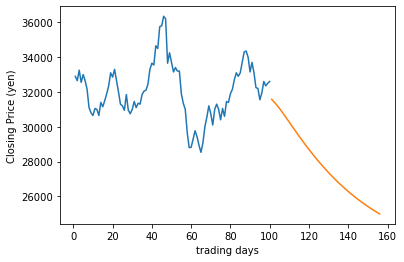

In [30]:
# see how our predictions add on to the end of closing stock prices
day_new=np.arange(1,101)
day_pred=np.arange(101,101+forecast_days)
days_end=len(one_stock_scaler)-100
plt.plot(day_new,scaler.inverse_transform(one_stock_scaler[days_end:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("trading days")
plt.ylabel("Closing Price (yen)")

In [31]:
# create a new df with predictions
predicted_one_stock_df=one_stock_df.copy()
predicted_scalar=scaler.inverse_transform(lst_output)
predicted_values=predicted_scalar.tolist()
total_days=len(one_stock_df)
new_date=one_stock_df['Date'][total_days-1]
security_code=one_stock_df['SecuritiesCode'][0]

for count,value in enumerate(predicted_values):
    new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    while new_date.weekday()==5 or new_date.weekday()==6 or new_date.date() in Japan_Holidays_2019to2022:
        new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    predicted_one_stock_df.loc[len(predicted_one_stock_df.index)] = [new_date.date(), security_code, value[0]]                 

Text(0, 0.5, 'Closing Price (yen)')

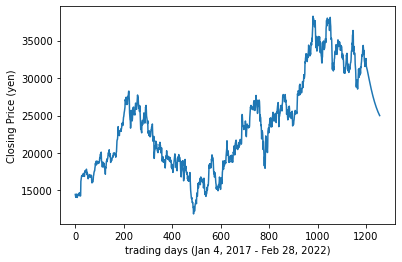

In [32]:
# look at a plot of the close prices for one stock including forecast day predictions
plt.plot(predicted_one_stock_df['Close'])
plt.xlabel("trading days (Jan 4, 2017 - Feb 28, 2022)")
plt.ylabel("Closing Price (yen)")

# analyze TSE 6861

In [33]:
# remove previous model data
tf.keras.backend.clear_session()

In [34]:
# grab just one stock 
one_stock_df=close_df.loc[close_df['SecuritiesCode']==6861]
one_stock_df=one_stock_df.dropna()
one_stock_df.reset_index(drop=True, inplace=True)
one_stock_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,6861,81000.0
1,2017-01-05,6861,82890.0
2,2017-01-06,6861,83400.0
3,2017-01-10,6861,82840.0
4,2017-01-11,6861,83170.0


In [35]:
len(one_stock_df)

1201

In [36]:
# convert Date column to datetime 
one_stock_df['Date'] = pd.to_datetime(one_stock_df['Date']).dt.date
one_stock_df.dtypes

Date               object
SecuritiesCode      int64
Close             float64
dtype: object

In [37]:
# only use the Close column for predicting
one_stock_close_df=one_stock_df.reset_index()['Close']
one_stock_close_df.head()

0    81000.0
1    82890.0
2    83400.0
3    82840.0
4    83170.0
Name: Close, dtype: float64

Text(0, 0.5, 'Closing Price (yen)')

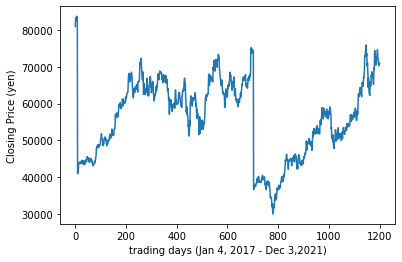

In [38]:
# look at a plot of the close prices for one stock
plt.plot(one_stock_close_df)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")

In [39]:
### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
one_stock_scaler

array([[0.94819423],
       [0.98328846],
       [0.99275833],
       ...,
       [0.75248352],
       [0.76176771],
       [0.76269613]])

In [40]:
# splitting the dataset into train and test splits
training_size=int(len(one_stock_scaler)*0.65)
test_size=len(one_stock_scaler)-training_size
train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]

In [41]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = input_parameters
X_train, y_train=create_dataset(train_data, time_step)
X_test, y_test=create_dataset(test_data, time_step)

In [42]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [43]:
# Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(int(input_parameters/2),return_sequences=True,input_shape=(input_parameters,1)))
model.add(LSTM(int(input_parameters/2),return_sequences=True))
model.add(LSTM(int(input_parameters/2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [44]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=64,verbose=1)

Epoch 1/15
11/11 [==============================] - 5s 187ms/step - loss: 0.1054 - val_loss: 0.0054
Epoch 2/15
11/11 [==============================] - 1s 93ms/step - loss: 0.0187 - val_loss: 0.0062
Epoch 3/15
11/11 [==============================] - 1s 93ms/step - loss: 0.0137 - val_loss: 0.0078
Epoch 4/15
11/11 [==============================] - 1s 90ms/step - loss: 0.0121 - val_loss: 0.0053
Epoch 5/15
11/11 [==============================] - 1s 102ms/step - loss: 0.0098 - val_loss: 0.0047
Epoch 6/15
11/11 [==============================] - 1s 83ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 7/15
11/11 [==============================] - 1s 88ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 8/15
11/11 [==============================] - 1s 94ms/step - loss: 0.0083 - val_loss: 0.0040
Epoch 9/15
11/11 [==============================] - 1s 95ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 10/15
11/11 [==============================] - 1s 94ms/step - loss: 0.0077 - val_loss: 0.0029
Epoch 1

In [45]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [46]:
# transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [47]:
# calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

61418.99185207353

In [48]:
# test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

57904.88878957803

In [49]:
# calculate mean_absolute error - train data
from sklearn.metrics import mean_absolute_error as mae
mae(y_train,train_predict)

60879.38696014831

In [50]:
# test data mae
mae(y_test,test_predict)

57486.57773228969

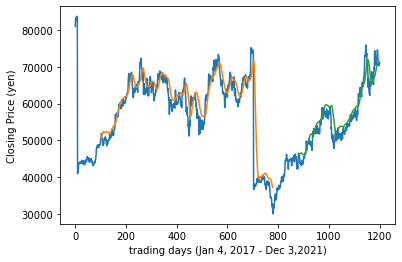

In [51]:
# Plotting
# shift train predictions for plotting
look_back=input_parameters
trainPredictPlot=np.empty_like(one_stock_scaler)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
# shift test predictions for plotting
testPredictPlot=np.empty_like(one_stock_scaler)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(one_stock_scaler)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(one_stock_scaler))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")
plt.show()

In [52]:
# setup to predict future stock prices
input_start=len(test_data)-input_parameters
x_input=test_data[input_start:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [53]:
# predictions for the amount of forecast days  
from numpy import array

lst_output=[]
n_steps=input_parameters
i=0

while(i<forecast_days):
        if(len(temp_input)>input_parameters):
            x_input=np.array(temp_input[1:])
            print("{} day input  {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1    

[0.76455575]
101
1 day input  [0.48974097 0.52984867 0.53486213 0.53207687 0.51332281 0.51239439
 0.47804289 0.47265806 0.48268499 0.51239439 0.5214929  0.50255315
 0.52093585 0.57199889 0.6050506  0.6072788  0.5935382  0.59502367
 0.5981803  0.62083372 0.63624547 0.63030359 0.6394021  0.60894996
 0.60746449 0.60412218 0.60245103 0.59316684 0.6473865  0.66521214
 0.66261257 0.65258565 0.64460124 0.65834184 0.67208244 0.68990809
 0.68879398 0.71478971 0.73020147 0.79333395 0.8007613  0.79649058
 0.81821558 0.84606815 0.85498097 0.84625383 0.80113267 0.81078823
 0.77420852 0.74802711 0.76251044 0.72890168 0.69714975 0.63977347
 0.68823693 0.65072881 0.6256615  0.60894996 0.60857859 0.59966577
 0.63754526 0.66874014 0.64775787 0.64682945 0.65685637 0.7012348
 0.69232198 0.71906044 0.71441835 0.69287903 0.69213629 0.68563736
 0.68378052 0.66539783 0.6553709  0.71627518 0.74115681 0.73001578
 0.81784421 0.82564293 0.78962028 0.77885062 0.7561972  0.75285489
 0.76195339 0.77160895 0.78813481

10 day output [[0.7429562]]
11 day input  [0.5214929  0.50255315 0.52093585 0.57199889 0.6050506  0.6072788
 0.5935382  0.59502367 0.5981803  0.62083372 0.63624547 0.63030359
 0.6394021  0.60894996 0.60746449 0.60412218 0.60245103 0.59316684
 0.6473865  0.66521214 0.66261257 0.65258565 0.64460124 0.65834184
 0.67208244 0.68990809 0.68879398 0.71478971 0.73020147 0.79333395
 0.8007613  0.79649058 0.81821558 0.84606815 0.85498097 0.84625383
 0.80113267 0.81078823 0.77420852 0.74802711 0.76251044 0.72890168
 0.69714975 0.63977347 0.68823693 0.65072881 0.6256615  0.60894996
 0.60857859 0.59966577 0.63754526 0.66874014 0.64775787 0.64682945
 0.65685637 0.7012348  0.69232198 0.71906044 0.71441835 0.69287903
 0.69213629 0.68563736 0.68378052 0.66539783 0.6553709  0.71627518
 0.74115681 0.73001578 0.81784421 0.82564293 0.78962028 0.77885062
 0.7561972  0.75285489 0.76195339 0.77160895 0.78813481 0.79556216
 0.80930276 0.83009934 0.82341472 0.78534955 0.78349271 0.76139634
 0.7573113  0.7500696

20 day output [[0.73035264]]
21 day input  [0.63624547 0.63030359 0.6394021  0.60894996 0.60746449 0.60412218
 0.60245103 0.59316684 0.6473865  0.66521214 0.66261257 0.65258565
 0.64460124 0.65834184 0.67208244 0.68990809 0.68879398 0.71478971
 0.73020147 0.79333395 0.8007613  0.79649058 0.81821558 0.84606815
 0.85498097 0.84625383 0.80113267 0.81078823 0.77420852 0.74802711
 0.76251044 0.72890168 0.69714975 0.63977347 0.68823693 0.65072881
 0.6256615  0.60894996 0.60857859 0.59966577 0.63754526 0.66874014
 0.64775787 0.64682945 0.65685637 0.7012348  0.69232198 0.71906044
 0.71441835 0.69287903 0.69213629 0.68563736 0.68378052 0.66539783
 0.6553709  0.71627518 0.74115681 0.73001578 0.81784421 0.82564293
 0.78962028 0.77885062 0.7561972  0.75285489 0.76195339 0.77160895
 0.78813481 0.79556216 0.80930276 0.83009934 0.82341472 0.78534955
 0.78349271 0.76139634 0.7573113  0.75006963 0.75248352 0.76176771
 0.76269613 0.76455575 0.76191753 0.75929153 0.75676197 0.75437129
 0.75213438 0.75004

30 day output [[0.7224356]]
31 day input  [0.66261257 0.65258565 0.64460124 0.65834184 0.67208244 0.68990809
 0.68879398 0.71478971 0.73020147 0.79333395 0.8007613  0.79649058
 0.81821558 0.84606815 0.85498097 0.84625383 0.80113267 0.81078823
 0.77420852 0.74802711 0.76251044 0.72890168 0.69714975 0.63977347
 0.68823693 0.65072881 0.6256615  0.60894996 0.60857859 0.59966577
 0.63754526 0.66874014 0.64775787 0.64682945 0.65685637 0.7012348
 0.69232198 0.71906044 0.71441835 0.69287903 0.69213629 0.68563736
 0.68378052 0.66539783 0.6553709  0.71627518 0.74115681 0.73001578
 0.81784421 0.82564293 0.78962028 0.77885062 0.7561972  0.75285489
 0.76195339 0.77160895 0.78813481 0.79556216 0.80930276 0.83009934
 0.82341472 0.78534955 0.78349271 0.76139634 0.7573113  0.75006963
 0.75248352 0.76176771 0.76269613 0.76455575 0.76191753 0.75929153
 0.75676197 0.75437129 0.75213438 0.75004911 0.74810416 0.74628389
 0.74457276 0.74295622 0.74142224 0.73996156 0.73856694 0.73723322
 0.73595637 0.7347339

41 day output [[0.7172806]]
42 day input  [0.79649058 0.81821558 0.84606815 0.85498097 0.84625383 0.80113267
 0.81078823 0.77420852 0.74802711 0.76251044 0.72890168 0.69714975
 0.63977347 0.68823693 0.65072881 0.6256615  0.60894996 0.60857859
 0.59966577 0.63754526 0.66874014 0.64775787 0.64682945 0.65685637
 0.7012348  0.69232198 0.71906044 0.71441835 0.69287903 0.69213629
 0.68563736 0.68378052 0.66539783 0.6553709  0.71627518 0.74115681
 0.73001578 0.81784421 0.82564293 0.78962028 0.77885062 0.7561972
 0.75285489 0.76195339 0.77160895 0.78813481 0.79556216 0.80930276
 0.83009934 0.82341472 0.78534955 0.78349271 0.76139634 0.7573113
 0.75006963 0.75248352 0.76176771 0.76269613 0.76455575 0.76191753
 0.75929153 0.75676197 0.75437129 0.75213438 0.75004911 0.74810416
 0.74628389 0.74457276 0.74295622 0.74142224 0.73996156 0.73856694
 0.73723322 0.73595637 0.73473394 0.73356384 0.73244476 0.73137492
 0.73035264 0.72937715 0.72844678 0.72755986 0.72671479 0.72591013
 0.72514439 0.72441554

52 day output [[0.7143355]]
53 day input  [0.69714975 0.63977347 0.68823693 0.65072881 0.6256615  0.60894996
 0.60857859 0.59966577 0.63754526 0.66874014 0.64775787 0.64682945
 0.65685637 0.7012348  0.69232198 0.71906044 0.71441835 0.69287903
 0.69213629 0.68563736 0.68378052 0.66539783 0.6553709  0.71627518
 0.74115681 0.73001578 0.81784421 0.82564293 0.78962028 0.77885062
 0.7561972  0.75285489 0.76195339 0.77160895 0.78813481 0.79556216
 0.80930276 0.83009934 0.82341472 0.78534955 0.78349271 0.76139634
 0.7573113  0.75006963 0.75248352 0.76176771 0.76269613 0.76455575
 0.76191753 0.75929153 0.75676197 0.75437129 0.75213438 0.75004911
 0.74810416 0.74628389 0.74457276 0.74295622 0.74142224 0.73996156
 0.73856694 0.73723322 0.73595637 0.73473394 0.73356384 0.73244476
 0.73137492 0.73035264 0.72937715 0.72844678 0.72755986 0.72671479
 0.72591013 0.72514439 0.72441554 0.72372204 0.72306275 0.72243559
 0.72183943 0.72127253 0.7207337  0.7202214  0.71973455 0.71927178
 0.71883202 0.718414

Text(0, 0.5, 'Closing Price (yen)')

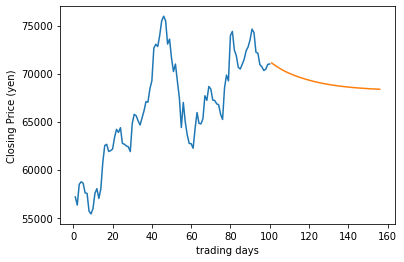

In [54]:
# see how our predictions add on to the end of closing stock prices
day_new=np.arange(1,101)
day_pred=np.arange(101,101+forecast_days)
days_end=len(one_stock_scaler)-100
plt.plot(day_new,scaler.inverse_transform(one_stock_scaler[days_end:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("trading days")
plt.ylabel("Closing Price (yen)")

In [55]:
# create a new df with predictions
predicted_one_stock_df=one_stock_df.copy()
predicted_scalar=scaler.inverse_transform(lst_output)
predicted_values=predicted_scalar.tolist()
total_days=len(one_stock_df)
new_date=one_stock_df['Date'][total_days-1]
security_code=one_stock_df['SecuritiesCode'][0]

for count,value in enumerate(predicted_values):
    new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    while new_date.weekday()==5 or new_date.weekday()==6 or new_date.date() in Japan_Holidays_2019to2022:
        new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    predicted_one_stock_df.loc[len(predicted_one_stock_df.index)] = [new_date.date(), security_code, value[0]]                 

Text(0, 0.5, 'Closing Price (yen)')

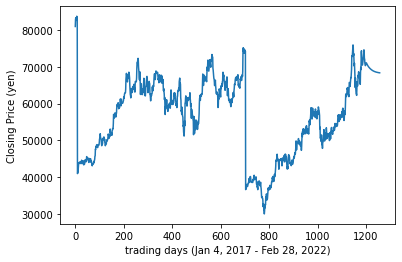

In [56]:
# look at a plot of the close prices for one stock including forecast day predictions
plt.plot(predicted_one_stock_df['Close'])
plt.xlabel("trading days (Jan 4, 2017 - Feb 28, 2022)")
plt.ylabel("Closing Price (yen)")

# analyze TSE 7974

In [57]:
# remove previous model data
tf.keras.backend.clear_session()

In [58]:
# grab just one stock 
one_stock_df=close_df.loc[close_df['SecuritiesCode']==7974]
one_stock_df=one_stock_df.dropna()
one_stock_df.reset_index(drop=True, inplace=True)
one_stock_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,7974,24480.0
1,2017-01-05,7974,24085.0
2,2017-01-06,7974,24050.0
3,2017-01-10,7974,24370.0
4,2017-01-11,7974,25145.0


In [59]:
len(one_stock_df)

1201

In [60]:
# convert Date column to datetime 
one_stock_df['Date'] = pd.to_datetime(one_stock_df['Date']).dt.date
one_stock_df.dtypes

Date               object
SecuritiesCode      int64
Close             float64
dtype: object

Text(0, 0.5, 'Closing Price (yen)')

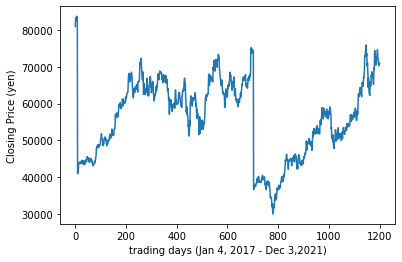

In [61]:
# look at a plot of the close prices for one stock
plt.plot(one_stock_close_df)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")

In [62]:
### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
one_stock_scaler

array([[0.94819423],
       [0.98328846],
       [0.99275833],
       ...,
       [0.75248352],
       [0.76176771],
       [0.76269613]])

In [63]:
# splitting the dataset into train and test splits
training_size=int(len(one_stock_scaler)*0.65)
test_size=len(one_stock_scaler)-training_size
train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]

In [64]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = input_parameters
X_train, y_train=create_dataset(train_data, time_step)
X_test, y_test=create_dataset(test_data, time_step)

In [65]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [66]:
# Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(int(input_parameters/2),return_sequences=True,input_shape=(input_parameters,1)))
model.add(LSTM(int(input_parameters/2),return_sequences=True))
model.add(LSTM(int(input_parameters/2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [67]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=64,verbose=1)

Epoch 1/15
11/11 [==============================] - 5s 178ms/step - loss: 0.0832 - val_loss: 0.0081
Epoch 2/15
11/11 [==============================] - 1s 90ms/step - loss: 0.0192 - val_loss: 0.0066
Epoch 3/15
11/11 [==============================] - 1s 90ms/step - loss: 0.0121 - val_loss: 0.0061
Epoch 4/15
11/11 [==============================] - 1s 92ms/step - loss: 0.0111 - val_loss: 0.0048
Epoch 5/15
11/11 [==============================] - 1s 97ms/step - loss: 0.0091 - val_loss: 0.0041
Epoch 6/15
11/11 [==============================] - 1s 89ms/step - loss: 0.0087 - val_loss: 0.0035
Epoch 7/15
11/11 [==============================] - 1s 85ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 8/15
11/11 [==============================] - 1s 95ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 9/15
11/11 [==============================] - 1s 99ms/step - loss: 0.0074 - val_loss: 0.0026
Epoch 10/15
11/11 [==============================] - 1s 103ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 1

In [68]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [69]:
# transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [70]:
# calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

59323.9672990485

In [71]:
# test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

55700.78560823694

In [72]:
# calculate mean_absolute error - train data
from sklearn.metrics import mean_absolute_error as mae
mae(y_train,train_predict)

58785.836305463105

In [73]:
# test data mae
mae(y_test,test_predict)

55258.94788609828

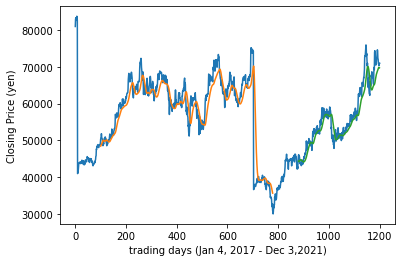

In [74]:
# Plotting
# shift train predictions for plotting
look_back=input_parameters
trainPredictPlot=np.empty_like(one_stock_scaler)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
# shift test predictions for plotting
testPredictPlot=np.empty_like(one_stock_scaler)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(one_stock_scaler)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(one_stock_scaler))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")
plt.show()

In [75]:
# setup to predict future stock prices
input_start=len(test_data)-input_parameters
x_input=test_data[input_start:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [76]:
# predictions for the amount of forecast days  
from numpy import array

lst_output=[]
n_steps=input_parameters
i=0

while(i<forecast_days):
        if(len(temp_input)>input_parameters):
            x_input=np.array(temp_input[1:])
            print("{} day input  {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1                    

[0.73471135]
101
1 day input  [0.48974097 0.52984867 0.53486213 0.53207687 0.51332281 0.51239439
 0.47804289 0.47265806 0.48268499 0.51239439 0.5214929  0.50255315
 0.52093585 0.57199889 0.6050506  0.6072788  0.5935382  0.59502367
 0.5981803  0.62083372 0.63624547 0.63030359 0.6394021  0.60894996
 0.60746449 0.60412218 0.60245103 0.59316684 0.6473865  0.66521214
 0.66261257 0.65258565 0.64460124 0.65834184 0.67208244 0.68990809
 0.68879398 0.71478971 0.73020147 0.79333395 0.8007613  0.79649058
 0.81821558 0.84606815 0.85498097 0.84625383 0.80113267 0.81078823
 0.77420852 0.74802711 0.76251044 0.72890168 0.69714975 0.63977347
 0.68823693 0.65072881 0.6256615  0.60894996 0.60857859 0.59966577
 0.63754526 0.66874014 0.64775787 0.64682945 0.65685637 0.7012348
 0.69232198 0.71906044 0.71441835 0.69287903 0.69213629 0.68563736
 0.68378052 0.66539783 0.6553709  0.71627518 0.74115681 0.73001578
 0.81784421 0.82564293 0.78962028 0.77885062 0.7561972  0.75285489
 0.76195339 0.77160895 0.78813481

11 day output [[0.6917256]]
12 day input  [0.50255315 0.52093585 0.57199889 0.6050506  0.6072788  0.5935382
 0.59502367 0.5981803  0.62083372 0.63624547 0.63030359 0.6394021
 0.60894996 0.60746449 0.60412218 0.60245103 0.59316684 0.6473865
 0.66521214 0.66261257 0.65258565 0.64460124 0.65834184 0.67208244
 0.68990809 0.68879398 0.71478971 0.73020147 0.79333395 0.8007613
 0.79649058 0.81821558 0.84606815 0.85498097 0.84625383 0.80113267
 0.81078823 0.77420852 0.74802711 0.76251044 0.72890168 0.69714975
 0.63977347 0.68823693 0.65072881 0.6256615  0.60894996 0.60857859
 0.59966577 0.63754526 0.66874014 0.64775787 0.64682945 0.65685637
 0.7012348  0.69232198 0.71906044 0.71441835 0.69287903 0.69213629
 0.68563736 0.68378052 0.66539783 0.6553709  0.71627518 0.74115681
 0.73001578 0.81784421 0.82564293 0.78962028 0.77885062 0.7561972
 0.75285489 0.76195339 0.77160895 0.78813481 0.79556216 0.80930276
 0.83009934 0.82341472 0.78534955 0.78349271 0.76139634 0.7573113
 0.75006963 0.75248352 0.7

22 day output [[0.6529495]]
23 day input  [0.6394021  0.60894996 0.60746449 0.60412218 0.60245103 0.59316684
 0.6473865  0.66521214 0.66261257 0.65258565 0.64460124 0.65834184
 0.67208244 0.68990809 0.68879398 0.71478971 0.73020147 0.79333395
 0.8007613  0.79649058 0.81821558 0.84606815 0.85498097 0.84625383
 0.80113267 0.81078823 0.77420852 0.74802711 0.76251044 0.72890168
 0.69714975 0.63977347 0.68823693 0.65072881 0.6256615  0.60894996
 0.60857859 0.59966577 0.63754526 0.66874014 0.64775787 0.64682945
 0.65685637 0.7012348  0.69232198 0.71906044 0.71441835 0.69287903
 0.69213629 0.68563736 0.68378052 0.66539783 0.6553709  0.71627518
 0.74115681 0.73001578 0.81784421 0.82564293 0.78962028 0.77885062
 0.7561972  0.75285489 0.76195339 0.77160895 0.78813481 0.79556216
 0.80930276 0.83009934 0.82341472 0.78534955 0.78349271 0.76139634
 0.7573113  0.75006963 0.75248352 0.76176771 0.76269613 0.73471135
 0.73183864 0.72850841 0.72480792 0.72084063 0.71670443 0.7124818
 0.70823598 0.7040122

33 day output [[0.6219219]]
34 day input  [0.65834184 0.67208244 0.68990809 0.68879398 0.71478971 0.73020147
 0.79333395 0.8007613  0.79649058 0.81821558 0.84606815 0.85498097
 0.84625383 0.80113267 0.81078823 0.77420852 0.74802711 0.76251044
 0.72890168 0.69714975 0.63977347 0.68823693 0.65072881 0.6256615
 0.60894996 0.60857859 0.59966577 0.63754526 0.66874014 0.64775787
 0.64682945 0.65685637 0.7012348  0.69232198 0.71906044 0.71441835
 0.69287903 0.69213629 0.68563736 0.68378052 0.66539783 0.6553709
 0.71627518 0.74115681 0.73001578 0.81784421 0.82564293 0.78962028
 0.77885062 0.7561972  0.75285489 0.76195339 0.77160895 0.78813481
 0.79556216 0.80930276 0.83009934 0.82341472 0.78534955 0.78349271
 0.76139634 0.7573113  0.75006963 0.75248352 0.76176771 0.76269613
 0.73471135 0.73183864 0.72850841 0.72480792 0.72084063 0.71670443
 0.7124818  0.70823598 0.70401222 0.69984132 0.69574225 0.69172561
 0.68779594 0.68395448 0.68020004 0.67652988 0.67294115 0.66943055
 0.66599506 0.66263169

44 day output [[0.596456]]
45 day input  [0.85498097 0.84625383 0.80113267 0.81078823 0.77420852 0.74802711
 0.76251044 0.72890168 0.69714975 0.63977347 0.68823693 0.65072881
 0.6256615  0.60894996 0.60857859 0.59966577 0.63754526 0.66874014
 0.64775787 0.64682945 0.65685637 0.7012348  0.69232198 0.71906044
 0.71441835 0.69287903 0.69213629 0.68563736 0.68378052 0.66539783
 0.6553709  0.71627518 0.74115681 0.73001578 0.81784421 0.82564293
 0.78962028 0.77885062 0.7561972  0.75285489 0.76195339 0.77160895
 0.78813481 0.79556216 0.80930276 0.83009934 0.82341472 0.78534955
 0.78349271 0.76139634 0.7573113  0.75006963 0.75248352 0.76176771
 0.76269613 0.73471135 0.73183864 0.72850841 0.72480792 0.72084063
 0.71670443 0.7124818  0.70823598 0.70401222 0.69984132 0.69574225
 0.69172561 0.68779594 0.68395448 0.68020004 0.67652988 0.67294115
 0.66943055 0.66599506 0.66263169 0.65933824 0.65611136 0.65294951
 0.64985013 0.64681166 0.64383215 0.64090961 0.63804275 0.63522977
 0.63246924 0.6297594

Text(0, 0.5, 'Closing Price (yen)')

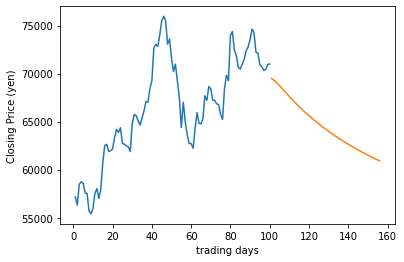

In [77]:
# see how our predictions add on to the end of closing stock prices
day_new=np.arange(1,101)
day_pred=np.arange(101,101+forecast_days)
days_end=len(one_stock_scaler)-100
plt.plot(day_new,scaler.inverse_transform(one_stock_scaler[days_end:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("trading days")
plt.ylabel("Closing Price (yen)")

In [78]:
# create a new df with predictions
predicted_one_stock_df=one_stock_df.copy()
predicted_scalar=scaler.inverse_transform(lst_output)
predicted_values=predicted_scalar.tolist()
total_days=len(one_stock_df)
new_date=one_stock_df['Date'][total_days-1]
security_code=one_stock_df['SecuritiesCode'][0]

for count,value in enumerate(predicted_values):
    new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    while new_date.weekday()==5 or new_date.weekday()==6 or new_date.date() in Japan_Holidays_2019to2022:
        new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    predicted_one_stock_df.loc[len(predicted_one_stock_df.index)] = [new_date.date(), security_code, value[0]]                 

Text(0, 0.5, 'Closing Price (yen)')

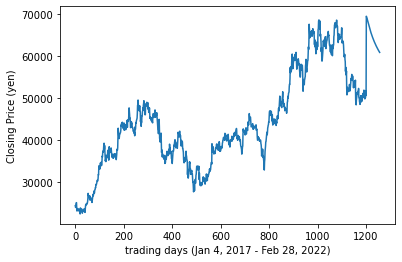

In [79]:
# look at a plot of the close prices for one stock including forecast day predictions
plt.plot(predicted_one_stock_df['Close'])
plt.xlabel("trading days (Jan 4, 2017 - Feb 28, 2022)")
plt.ylabel("Closing Price (yen)")